<a href="https://colab.research.google.com/github/dyjdlopez/demo-hybrid-quantum-nn/blob/main/demo_hqn_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Quantum Neural Networks Part 3: Quantum-ready Training with NVIDIA CUDA Quantum

Credits to Pika Wang for most of the demonstrations and dependencies!

In [1]:
#The following commands are used to set up the environment in Colab
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb
!dpkg -i cuda-keyring_1.0-1_all.deb
!apt-get update
!apt-get -y install libcublas-11-8 libcusolver-11-8 cuda-cudart-11-8

%pip install cuda-quantum==0.6.0

--2024-04-18 17:52:43--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.39.144
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4332 (4.2K) [application/x-deb]
Saving to: ‘cuda-keyring_1.0-1_all.deb’

cuda-keyring_1.0-1_ 100%[===================>]   4.23K  --.-KB/s    in 0s      

2024-04-18 17:52:43 (269 MB/s) - ‘cuda-keyring_1.0-1_all.deb’ saved [4332/4332]

(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack cuda-keyring_1.0-1_all.deb ...
Unpacking cuda-keyring (1.0-1) over (1.0-1) ...
Setting up cuda-keyring (1.0-1) ...

A deprecated public CUDA GPG key appear to be installed.
To remove the key, run this command:
sudo apt-key del 7fa2af80

Get:1 https://cloud.r-project.org/bin/linux/ubuntu ja

In [2]:
import cudaq
from cudaq import spin

from torch.autograd import Function
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

torch.manual_seed(42)
np.random.seed(42)

## 1. Importing the Data (MNIST)

In [3]:
# Training set.
sample_count = 140


X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

# Leaving only labels 0 and 1.
idx = np.append(
    np.where(X_train.targets == 0)[0][:sample_count],
    np.where(X_train.targets == 1)[0][:sample_count],
)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

# Test set.
sample_count = 70

X_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
idx = np.append(
    np.where(X_test.targets == 0)[0][:sample_count],
    np.where(X_test.targets == 1)[0][:sample_count],
)

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 372002212.24it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 81682868.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 207056417.37it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17590515.94it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 2. Check CUDA-Q Utilities and Configurations

In [4]:
# GPU utilities
cudaq.initialize_cudaq()
# cudaq.set_target("qpp-cpu")  # Set CUDAQ to run on GPU's
run_cpu = False
if run_cpu:
    cudaq.set_target("qpp-cpu")
    qdevice = "cpu"
else:
    cudaq.set_target("nvidia")
    qdevice = "cuda"


device = "cuda"

## 3. Defining the Quantum Layer

In [5]:
class QuantumFunction(Function):
    """Allows the quantum circuit to pass data through it and compute the gradients"""

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        """Define the quantum circuit in CUDA Quantum"""

        kernel, thetas = cudaq.make_kernel(list)

        self.kernel = kernel
        self.theta = thetas
        self.hamiltonian = hamiltonian

        qubits = kernel.qalloc(qubit_count)

        self.kernel.h(qubits)

        # Variational gate parameters which are optimised during training.
        self.kernel.ry(thetas[0], qubits[0])
        self.kernel.rx(thetas[1], qubits[0])

    def run(self, thetas: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        expectation = torch.tensor(cudaq.observe(self.kernel, spin.z(0),
                                                 thetas.tolist()).expectation(),
                                   device=device)

        return expectation

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate expectation value.
        expectation = ctx.quantum_circuit.run(thetas)

        ctx.save_for_backward(thetas, expectation)

        return expectation

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference parameter shift"""

        thetas, expectation = ctx.saved_tensors

        gradients = torch.zeros(len(thetas), device=device)

        for i in range(len(thetas)):
            shift_right = torch.clone(thetas)

            shift_right[i] += ctx.shift

            shift_left = torch.clone(thetas)

            shift_left[i] -= ctx.shift

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradients[i] = (expectation_right -
                            expectation_left) / 2 * ctx.shift

        return gradients * grad_output.float(), None, None

In [6]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, qubit_count: int, hamiltonian, shift: torch.tensor):
        super(QuantumLayer, self).__init__()

        # 1 qubit quantum circuit.
        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input):
        ans = QuantumFunction.apply(input, self.quantum_circuit, self.shift)

        return ans

## 4. Model Architecture

In [7]:
qubit_count = 1
hamiltonian = spin.z(0)
shift = torch.tensor(np.pi / 2)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Neural network structure.
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(
            64, 2
        )  # Output a 2D tensor since we have 2 variational parameters in our quantum circuit.
        self.hybrid = QuantumLayer(
            qubit_count, hamiltonian, shift
        )  # Input is the magnitude of the parameter shifts to calculate gradients.

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).reshape(
            -1
        )  # Reshapes required to satisfy input dimensions to CUDA Quantum.
        x = self.hybrid(x).reshape(-1)

        return torch.cat((x, 1 - x), -1).unsqueeze(0)

## 5. Model Training

In [8]:
# We move our model to the CUDA device to minimise data transfer between GPU and CPU.

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.NLLLoss().to(device)

epochs = 20

epoch_loss = []

model.train()
for epoch in tqdm(range(epochs)):
    batch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):  # Batch training.
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        # Forward pass.
        output = model(data).to(device)

        # Calculating loss.
        loss = loss_func(output, target).to(device)

        # Backward pass.
        loss.backward()

        # Optimize the weights.
        optimizer.step()

        batch_loss += loss.item()

    epoch_loss.append(batch_loss / batch_idx)

    print("Training [{:.0f}%]\tLoss: {:.4f}".format(
        100.0 * (epoch + 1) / epochs, epoch_loss[-1]))

  0%|          | 0/20 [00:00<?, ?it/s]

Training [5%]	Loss: -1.1814
Training [10%]	Loss: -1.3607
Training [15%]	Loss: -1.3872
Training [20%]	Loss: -1.4121
Training [25%]	Loss: -1.4214
Training [30%]	Loss: -1.4282
Training [35%]	Loss: -1.4466
Training [40%]	Loss: -1.4657
Training [45%]	Loss: -1.4695
Training [50%]	Loss: -1.4804
Training [55%]	Loss: -1.4820
Training [60%]	Loss: -1.4801
Training [65%]	Loss: -1.4844
Training [70%]	Loss: -1.4886
Training [75%]	Loss: -1.4939
Training [80%]	Loss: -1.4963
Training [85%]	Loss: -1.4964
Training [90%]	Loss: -1.4911
Training [95%]	Loss: -1.4948
Training [100%]	Loss: -1.4987


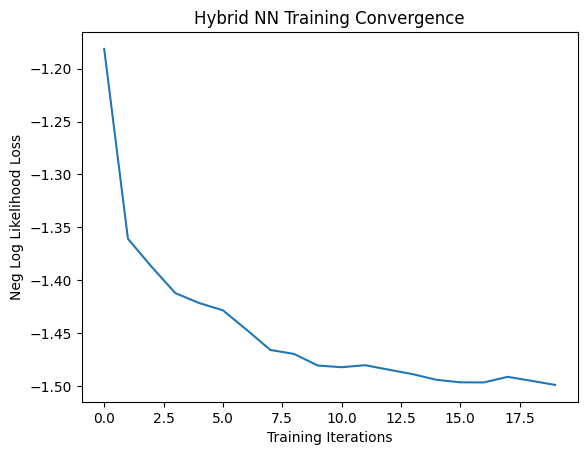

In [9]:
plt.plot(epoch_loss)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")

plt.ylabel("Neg Log Likelihood Loss")
plt.show()

In [10]:
# Testing on the test set.

model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data).to(device)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        epoch_loss.append(loss.item())

    print("Performance on test data:\n\tAccuracy: {:.1f}%".format(
        correct / len(test_loader) * 100))

Performance on test data:
	Accuracy: 100.0%
